# CS246 - Colab 3
## K-Means & PCA

### Setup

Let's set up Spark on your Colab environment.  Run the cell below!

In [2]:
!pip install pyspark
!pip install -U -q PyDrive
!apt install openjdk-8-jdk-headless -qq
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 2.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488491 sha256=d348c2c5c9d5b65b16c77ba78eea75a26d571a70b26048b317257d611a119074
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark
The following additional packages will be installed:
  libxtst6 openjdk-8-jre-headless
Suggested packages:
  openjdk-8-demo openjdk-8-source libnss-mdns fonts-dejavu-extra fonts-nanum fonts-ipafont-gothic
  fonts-ipafont-mincho fonts-wqy-microhei fonts-wqy-zenhei fonts-indic
The following NEW packages will be installed:
  libxtst6 openjdk-8-jdk-headless openjdk-8-jre-headless
0 upgraded, 3 newly installed, 0 to remove and 45 not upgraded.
Need to get 39.7 MB of archives.
After this operation, 144 MB of additional disk space will be used.
Selecting previously unselected package

Now we import some of the libraries usually needed by our workload.





In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
%matplotlib inline

import pyspark
from pyspark.sql import *
from pyspark.sql.types import *
from pyspark.sql.functions import *
from pyspark import SparkContext, SparkConf

Let's initialize the Spark context.

In [4]:
spark = SparkSession.builder \
    .appName('ElectionCampaignTweetsAnalysis') \
    .getOrCreate()
spark

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
def show_pandas_df(spark_df, limit = None, *columns):
    if not columns:
        if limit is not None:
            return spark_df.limit(limit).toPandas()
        else:
            return spark_df.toPandas()
    else:
        return spark_df.select(*columns).limit(limit).toPandas()

In [8]:
# Aqui fico alterando entre uma cópia mais leve além da mais pesada                     "debate-tweets_c2"
df = spark.read.option('header', 'false').option('delimiter', '\t').csv('./drive/MyDrive/debate-tweets_c2.tsv') \
    .withColumnRenamed('_c0', 'id').withColumnRenamed('_c1', 'text') \
    .withColumnRenamed('_c7', 'time_info').withColumnRenamed('_c8', 'day') \
    .select('id', 'text', 'time_info', 'day')

df = df.withColumn("time_info", to_timestamp(substring(df["time_info"], 12, 8), "HH:mm:ss"))
df = df.withColumn("hora_do_dia", hour(df["time_info"]))

In [9]:
df.show()

+------------------+--------------------+-------------------+----------+-----------+
|                id|                text|          time_info|       day|hora_do_dia|
+------------------+--------------------+-------------------+----------+-----------+
|522394422710136832|@anacddd verdade,...|1970-01-01 14:31:50|2014-10-15|         14|
|522394422806581248|              Que ñ*|1970-01-01 14:31:50|2014-10-15|         14|
|522394439655120897|mas hj começa a s...|1970-01-01 14:31:54|2014-10-15|         14|
|522394458563031041|Será que é só eu ...|1970-01-01 14:31:59|2014-10-15|         14|
|522394473582833665|MTV EMA | Vote - ...|1970-01-01 14:32:02|2014-10-15|         14|
|522394491345731584|E o seu corpo aca...|1970-01-01 14:32:07|2014-10-15|         14|
|522394509725143040|       Já foi hoje ?|1970-01-01 14:32:11|2014-10-15|         14|
|522394526204575746|@CircuitoBB ah, ó...|1970-01-01 14:32:15|2014-10-15|         14|
|522394541476048896|Essaa noite eu so...|1970-01-01 14:32:18|2014

In [10]:
@udf(returnType=StringType())
def categorizar_periodo(hora_do_dia):
    if hora_do_dia is not None:
        if 5 <= hora_do_dia < 12:
            return "manha"
        elif 12 <= hora_do_dia < 18:
            return "tarde"
        else:
            return "noite"
    else:
        return "sem_periodo"

@udf(returnType=ArrayType(StringType()))
def extrai_hashtags(text):
    return re.findall(r'#(\w+)', text)

In [71]:
new_df = df.withColumn("hashtags", extrai_hashtags(df["text"])) \
    .withColumn("periodo", categorizar_periodo(col('hora_do_dia'))) \
    .filter(size(col('hashtags')) > 0) \
    .withColumn('hashtag', explode("hashtags")) \
    .select('hashtag', 'periodo') \
    .groupBy('hashtag', 'periodo').count().orderBy(col('count').desc())

In [52]:
new_df.show()

+--------------------+-------+-----+
|             hashtag|periodo|count|
+--------------------+-------+-----+
|    EMABiggestFans1D|  noite| 1736|
|EMABiggestFansJus...|  noite| 1705|
|    EMABiggestFans1D|  tarde|  748|
|EMABiggestFansJus...|  tarde|  622|
|    EMABiggestFans1D|  manha|  232|
|EMABiggestFansJus...|  manha|  230|
|        camilasayshi|  noite|  129|
|          QueroNoTVZ|  tarde|   56|
|    bigpaynodanceoff|  noite|   54|
|           Vote5HEMA|  noite|   51|
|         StealMyGirl|  noite|   50|
|     CartersNewVideo|  noite|   49|
|         DebateNoSBT|  noite|   38|
|EМABiggestFansJus...|  noite|   32|
|      DebateNaRecord|  noite|   32|
|        KCAArgentina|  noite|   31|
|BuyLoveMeHarderOn...|  noite|   31|
|      TheVoiceBrasil|  noite|   29|
|LuanSantanaNaHora...|  noite|   29|
|         AssistamODR|  noite|   28|
+--------------------+-------+-----+
only showing top 20 rows



In [53]:
dfs = [new_df.filter(col('periodo') == x).limit(10).toPandas() for x in ['manha', 'tarde', 'noite']]

In [54]:
import seaborn as sns

def make_bar_plot(style, palette, figsize, x, y, data, title, xlabel, ylabel, fontsize):
    sns.set_style(style)
    sns.set_palette(palette)

    plt.figure(figsize=figsize)
    sns.barplot(x=x, y=y, data=data)

    plt.title(title, fontsize=fontsize)
    plt.xlabel(xlabel, fontsize=fontsize)
    plt.ylabel(ylabel, fontsize=fontsize)
    plt.xticks(fontsize=fontsize)
    plt.yticks(fontsize=fontsize)

    plt.show()

### HashTags Mais Frequentes

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 4448 (\N{HANGUL JUNGSEONG FILLER}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


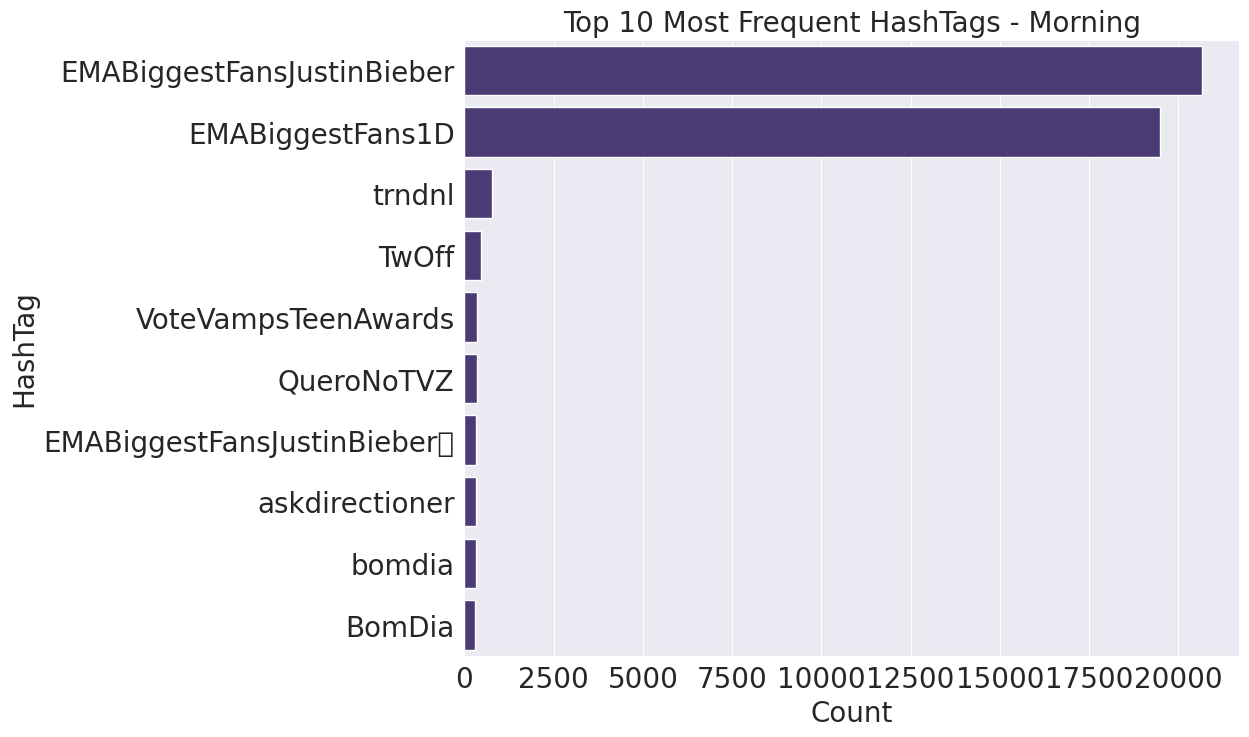

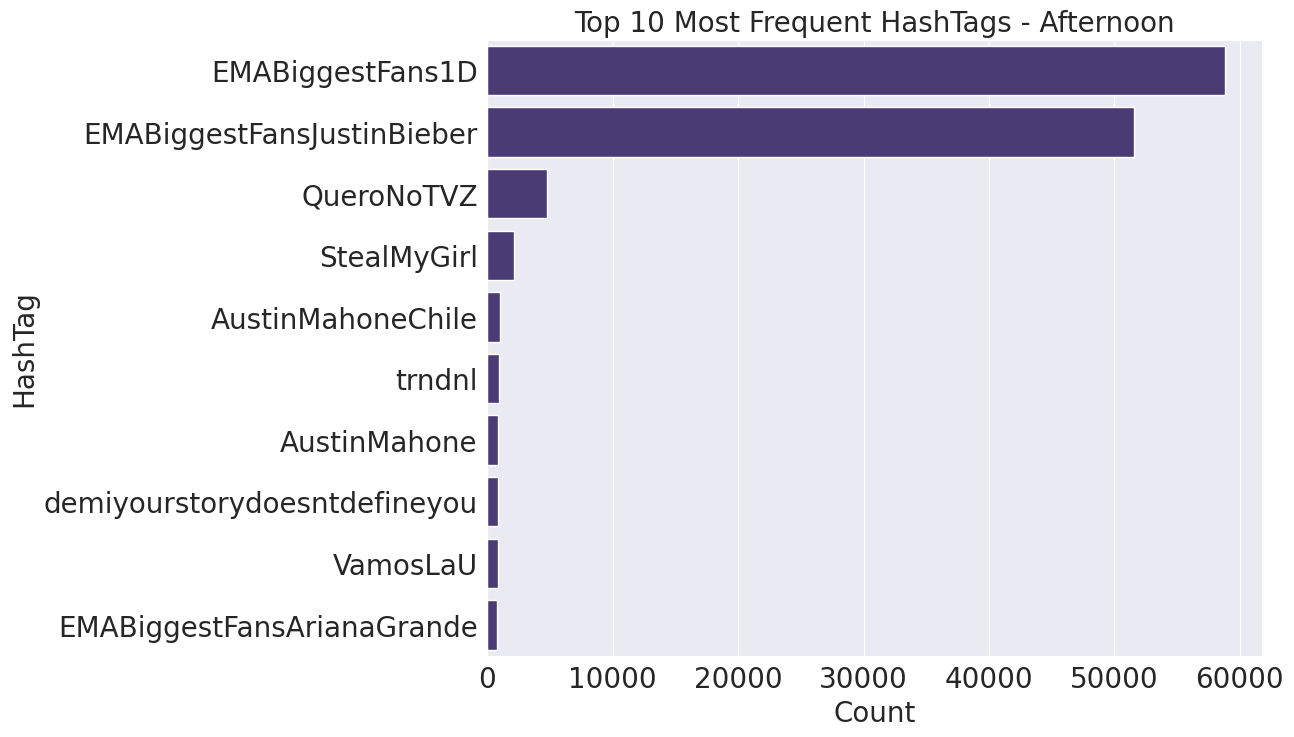

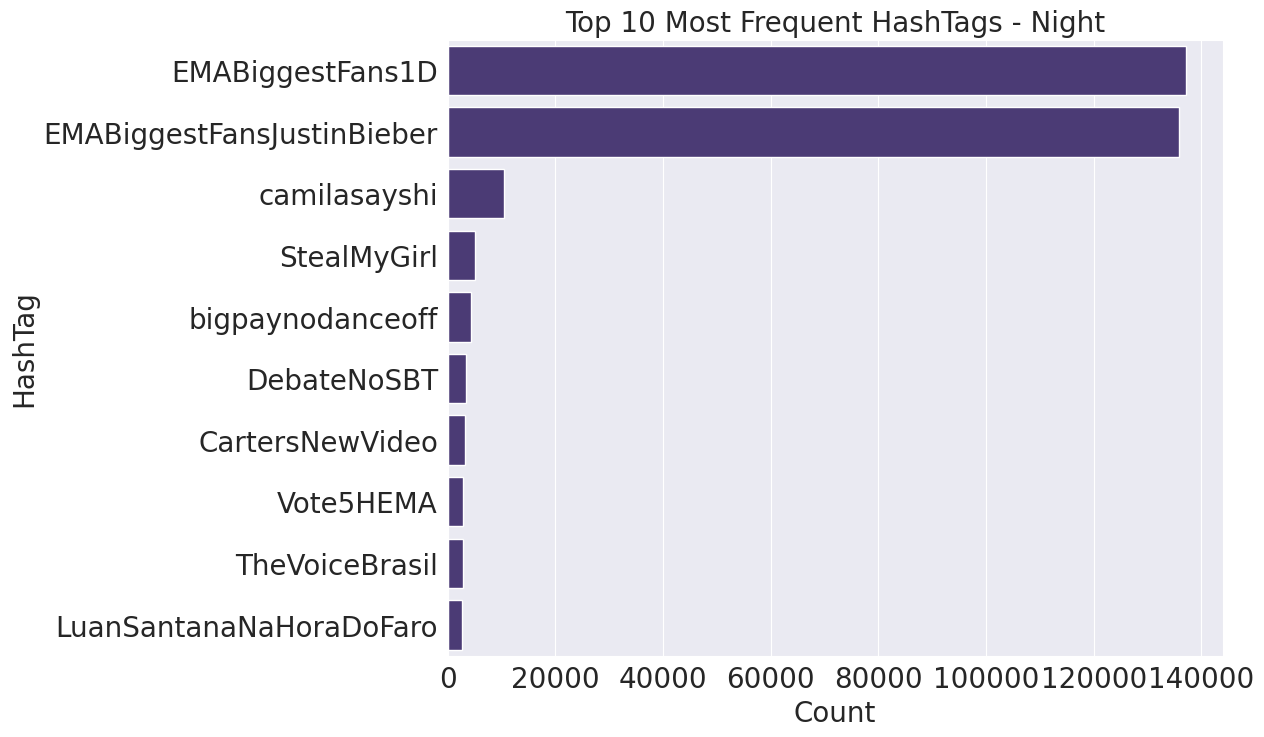

In [24]:
periodos = ['Morning', 'Afternoon', 'Night']

for i, periodo in enumerate(periodos):
    title = f'Top 10 Most Frequent HashTags - {periodo}'
    pandas_df = dfs[i]
    make_bar_plot("darkgrid", "viridis", (10, 8), 'count', 'hashtag', pandas_df, title, 'Count', 'HashTag', 12)

In [25]:
spark.stop()

### HashTags Mais Usadas em Cada Dia

In [72]:
new_df = df.withColumn("hashtags", extrai_hashtags(df["text"])) \
    .select("hashtags", "day") \
    .filter(size(col('hashtags')) > 0) \
    .withColumn('hashtag', explode("hashtags")) \
    .select('hashtag', 'day').dropna() \
    .groupBy('hashtag', 'day').count().orderBy(col('count').desc())

In [ ]:
new_df.show()

In [86]:
days = new_df.select('day').distinct().toPandas()['day'].sort_values().tolist()
print(days[1:])

# criar uma funcao so para isso
dfs = [new_df.filter(col('day') == x).limit(10).toPandas() for x in days[1:]]
dfs[0]

['2014-10-15', '2014-10-16', '2014-10-17', '2014-10-18', '2014-10-19', '2014-10-20']


,hashtag,day,count
0,EMABiggestFans1D,2014-10-15,34547
1,EMABiggestFansJustinBieber,2014-10-15,28105
2,StealMyGirl,2014-10-15,6280
3,bigpaynodanceoff,2014-10-15,4250
4,AssistamODR,2014-10-15,2435
5,BuyLoveMeHarderOniTunes,2014-10-15,1328
6,Vote5HEMA,2014-10-15,1294
7,UnlockMockingjay,2014-10-15,1183
8,QueroMuitosSeguidoresComValentino,2014-10-15,1008
9,NewE3Cover,2014-10-15,625


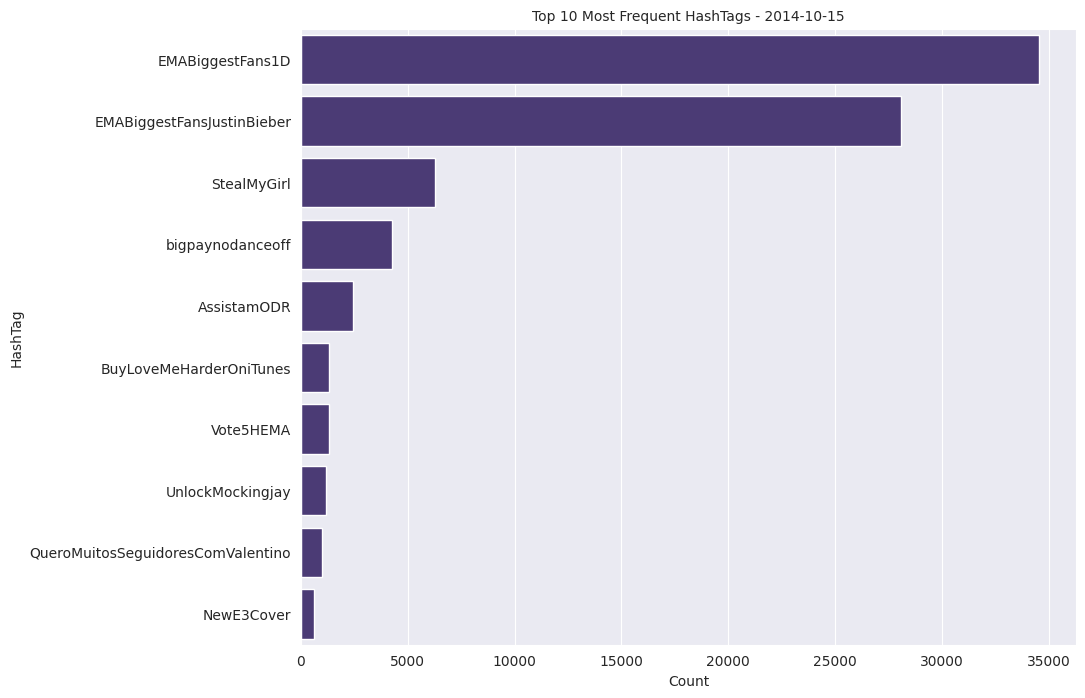

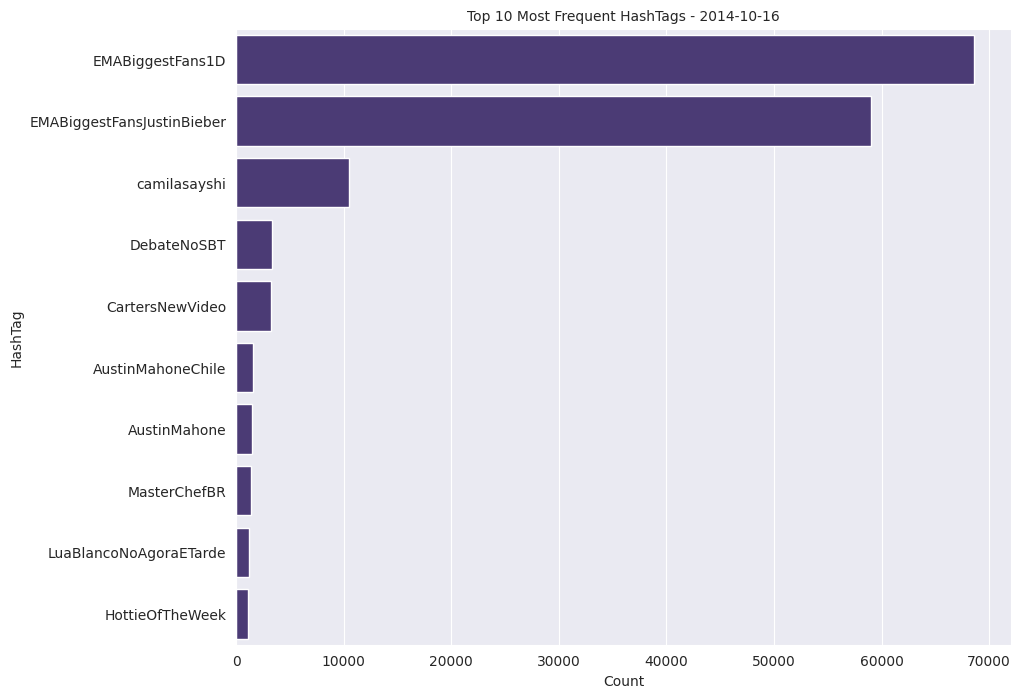

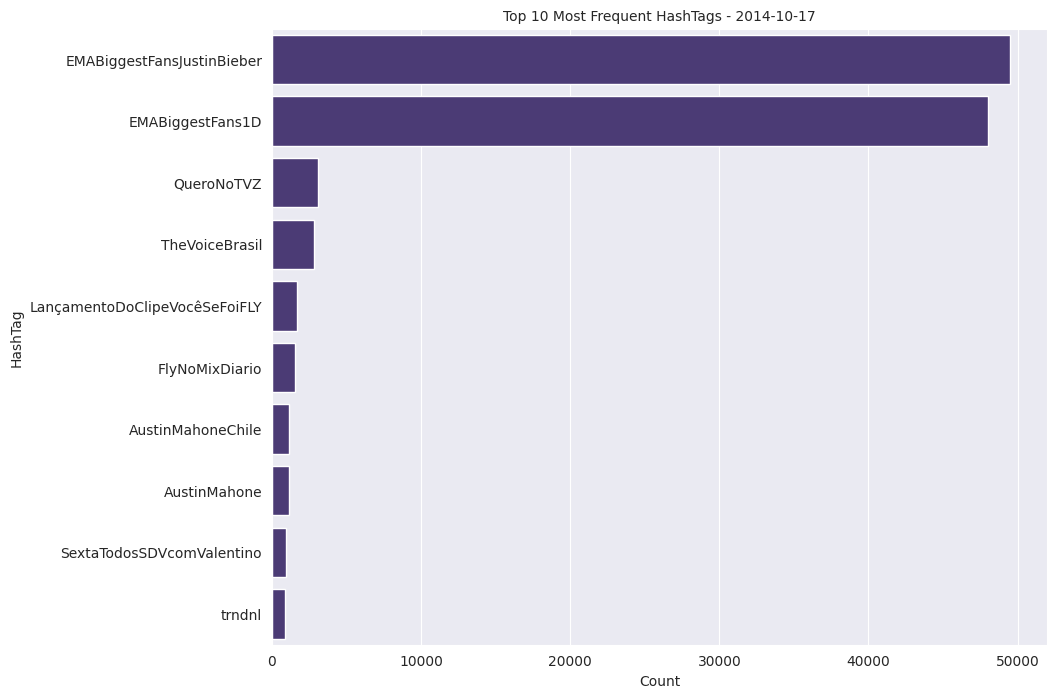

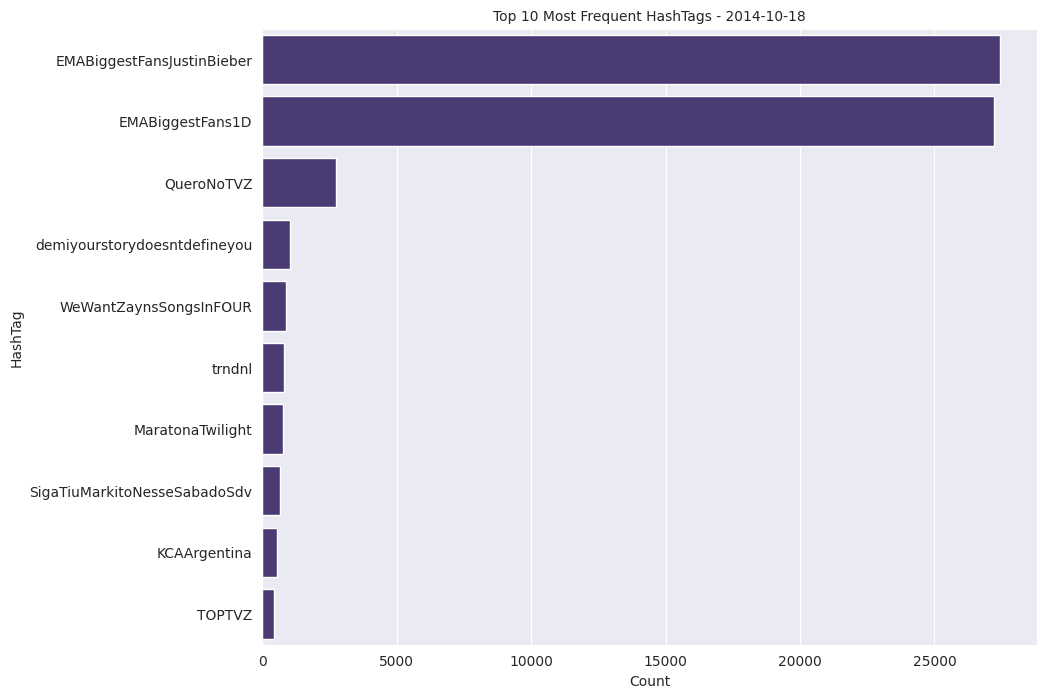

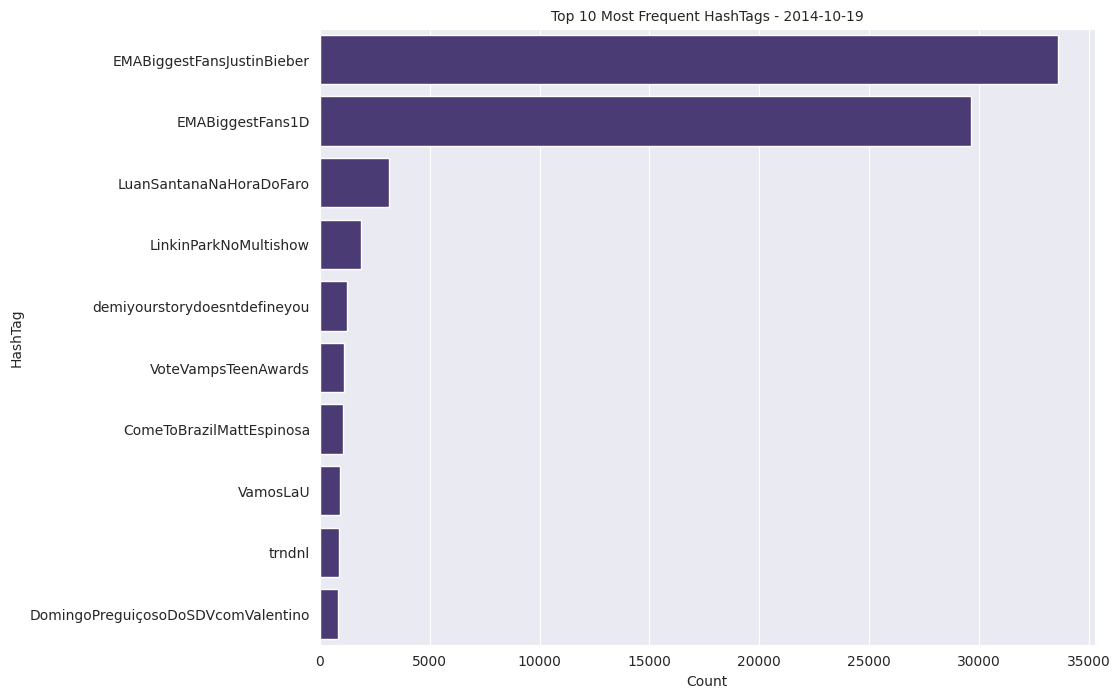

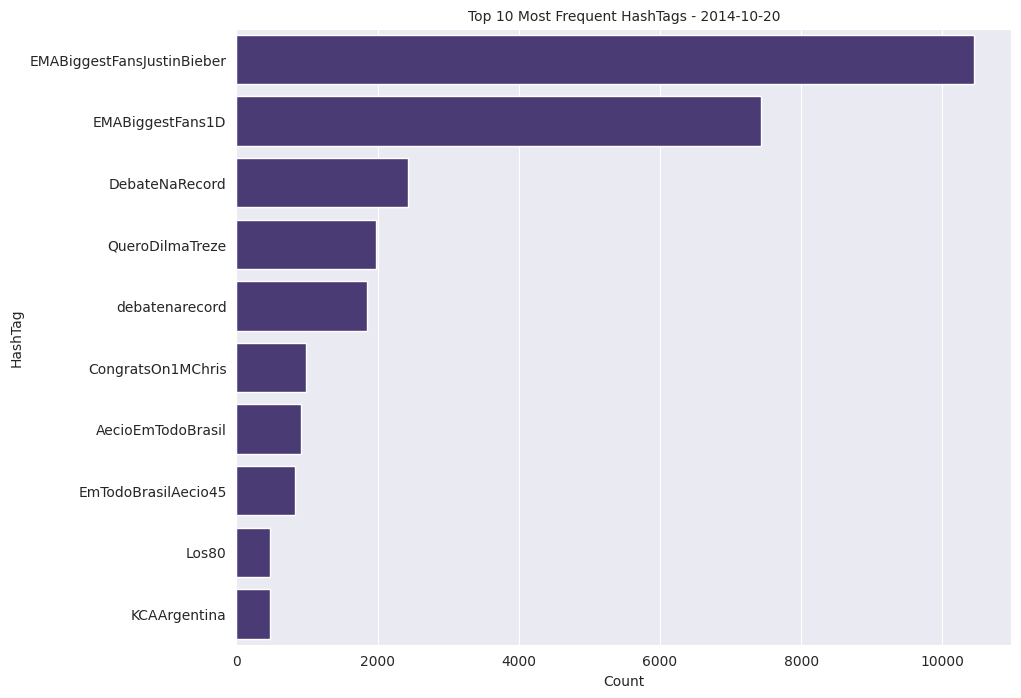

In [88]:
for i, day in enumerate(days[1:]):
    title = f'Top 10 Most Frequent HashTags - {day}'
    pandas_df = dfs[i]
    make_bar_plot("darkgrid", "viridis", (10, 8), 'count', 'hashtag', pandas_df, title, 'Count', 'HashTag', 10)

### Número de Tweets por Hora

In [32]:
new_df = df.select('hora_do_dia', 'id') \
  .groupBy('hora_do_dia') \
  .count().dropna() \
  .orderBy(col('hora_do_dia').desc()) \
  .toPandas()

In [33]:
new_df

,hora_do_dia,count
0,23,5047
1,22,4824
2,21,4426
3,20,4139
4,19,3957
5,18,4166
6,17,4410
7,16,4706
8,15,4713
9,14,3814


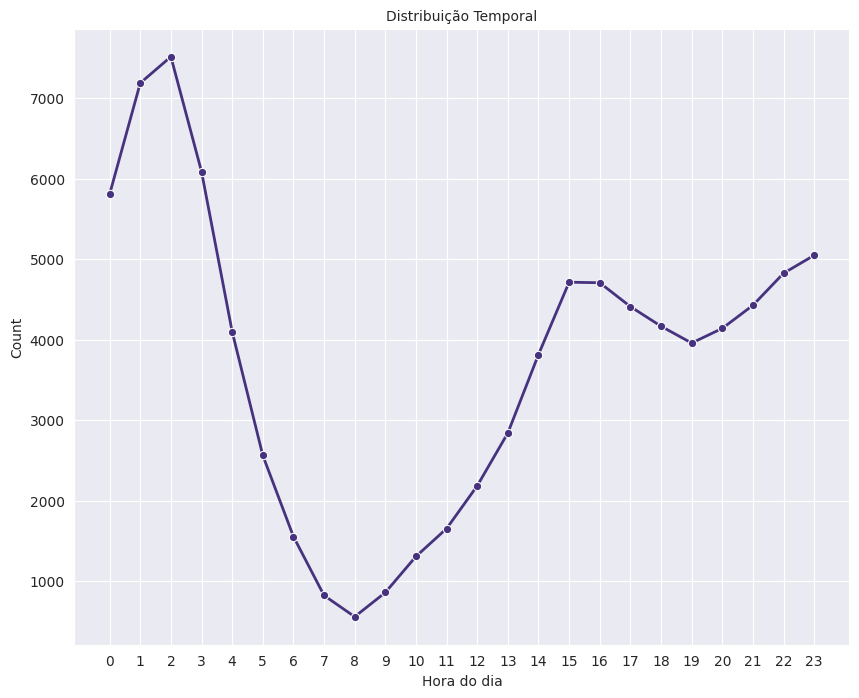

In [34]:
import seaborn as sns

sns.set_style("darkgrid")
sns.set_palette("viridis")

plt.figure(figsize=(10, 8))
sns.lineplot(x='hora_do_dia', y='count', data=new_df, linewidth=2, marker='o', sort=False)
plt.ylabel('Count', fontsize=10)
plt.xlabel('Hora do dia', fontsize=10)
plt.title('Distribuição Temporal', fontsize=10)
plt.grid(True)

plt.xticks(ticks=range(0, 24), fontsize=10)
plt.yticks(fontsize=10)
plt.show()